In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense,  Conv2D, MaxPooling2D, TimeDistributed, Flatten, InputLayer, Reshape, Conv1D, MaxPooling1D, Bidirectional, Dropout, ReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adadelta, SGD, Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import r2_score
import random
from datetime import datetime, timedelta
import math

#%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


random.seed(1)

Found GPU at: /device:GPU:0


In [34]:
print(tf.version.VERSION)

2.9.1


In [35]:
columns = ['Date/Time','DistrictCooling:Facility [J](Hourly)', 'DistrictHeating:Facility [J](Hourly)','InteriorLights:Electricity [J](Hourly)',
           'ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
           'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
           'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
           'Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly)',
           'Environment:Site Wind Speed [m/s](Hourly)',
           'Environment:Site Wind Direction [deg](Hourly)',
           'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)',
           'Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)',
           'Environment:Site Solar Azimuth Angle [deg](Hourly)',
           'Environment:Site Solar Altitude Angle [deg](Hourly)',]


In [36]:
def extract_columns_from_csv(file_name):
    # file_name = 'data/sim_2018.csv'
    df = pd.read_csv(file_name)
    new_df = pd.DataFrame(df, columns=columns)

    new_df['Temp_IN'] = new_df[['ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)']].mean(1)
    new_df.head()
    return new_df


In [37]:
def change_date_format(df, year):
    ts = []
    for item in df['Date/Time']:
        temp = item
        splitted = temp.split(' ')
        try:
            date = splitted[1]
            time = splitted[3]
        except Exception as e:
            date = splitted[0]
            time = splitted[2]
        if (time == '24:00:00'):
            time = '00:00:00'
        timestamp = datetime.strptime(f'{date}/{year} {time}', '%m/%d/%Y %H:%M:%S')
        if (time == '00:00:00'):
            timestamp += timedelta(days=1)
        ts.append(timestamp)
    df['Date/Time'] = pd.to_datetime(ts, format='%m/%d/%Y %H:%M:%S')
    return df

In [38]:
def separate_date(df):
    days = []
    months = []
    years = []
    hours = []
    minutes = []
    for timestamp in df['Date/Time']:
        days.append(timestamp.day)
        months.append(timestamp.month)
        years.append(timestamp.year)
        hours.append(timestamp.hour)
        minutes.append(timestamp.minute)

    new_df = pd.DataFrame()
    new_df['day'] = days
    new_df['month'] = months
    new_df['year'] = years
    new_df['hour'] = hours
    new_df['minute'] = minutes
    new_df.index = df.index
    return new_df

In [39]:
df_sim_2018 = extract_columns_from_csv('data/sim_2018.csv')
df_sim_2019 = extract_columns_from_csv('data/sim_2019.csv')
df_sim_2020 = extract_columns_from_csv('data/sim_2020.csv')
df_sim_2021 = extract_columns_from_csv('data/sim_2021.csv')

In [40]:
df_sim_2018 = change_date_format(df_sim_2018, '2018')
df_sim_2019 = change_date_format(df_sim_2019, '2019')
df_sim_2020 = change_date_format(df_sim_2020, '2020')
df_sim_2021 = change_date_format(df_sim_2021, '2021')
df_sim_2018.head()

,Date/Time,DistrictCooling:Facility [J](Hourly),DistrictHeating:Facility [J](Hourly),InteriorLights:Electricity [J](Hourly),ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON),...,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](Hourly),Temp_IN
0,2018-01-01 01:00:00,0.0,1.241507e+07,0.0,0.574975,17.489532,15.119142,16.393081,16.300784,18.684861,...,1.461069,-0.613889,95112.083333,0.000000,150.340909,0.0,0.0,9.218535,-67.993246,15.867405
1,2018-01-01 02:00:00,0.0,1.264940e+07,0.0,0.445273,17.092561,15.022540,16.341152,16.236156,18.701341,...,1.638889,-1.488889,95145.000000,0.000000,135.000000,0.0,0.0,34.159499,-64.819077,15.760236
2,2018-01-01 03:00:00,0.0,1.282862e+07,0.0,0.407038,16.959182,14.957004,16.303179,16.193096,18.712621,...,1.752315,-1.829167,95145.000000,0.023469,135.000000,0.0,0.0,58.222105,-57.144973,15.712835
3,2018-01-01 04:00:00,0.0,1.299398e+07,0.0,0.345275,16.857008,14.906273,16.271374,16.158931,18.721436,...,1.797980,-1.764941,95145.000000,0.016764,135.000000,0.0,0.0,74.474857,-47.428622,15.674921
4,2018-01-01 05:00:00,0.0,1.318382e+07,0.0,0.248806,16.767173,14.863758,16.243111,16.129659,18.728647,...,1.684933,-1.486532,95145.000000,0.000000,135.000000,0.0,0.0,86.722817,-36.964427,15.638247


In [41]:
df_train = pd.concat([df_sim_2018, df_sim_2019, df_sim_2020], axis=0)
df_train.reset_index(drop=True, inplace=True)
df_test = df_sim_2021

In [42]:
regressands = [
      'Temp_IN'
]
features = [
    'Temp_IN',
]

RUN OF THE MODEL

In [43]:
X_train = separate_date(df_train)

X_train = X_train.join(df_train[regressands])
X_train.describe()

,day,month,year,hour,minute,Temp_IN
count,26280.000000,26280.000000,26280.000000,26280.000000,26280.0,26280.000000
mean,15.721613,6.525989,2019.000114,11.500000,0.0,20.778189
std,8.796327,3.447961,0.816582,6.922318,0.0,4.260116
min,1.000000,1.000000,2018.000000,0.000000,0.0,14.412769
25%,8.000000,4.000000,2018.000000,5.750000,0.0,16.921788
50%,16.000000,7.000000,2019.000000,11.500000,0.0,19.513736
75%,23.000000,10.000000,2020.000000,17.250000,0.0,24.756853
max,31.000000,12.000000,2021.000000,23.000000,0.0,31.387367


In [44]:
X_train = X_train.astype('float32')
normalized_X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
normalized_X_train.dropna(axis=1, inplace=True)
y_train_min, y_train_max = X_train[regressands].min(), X_train[regressands].max()
y_train_mean, y_train_std = X_train[regressands].mean(), X_train[regressands].std()


In [46]:
past_hours = 24  # number of past values used to predict the next ones, in this case one hour (1)
next_hours = 1  # number of future sample to predict, in this case one hour (1)

In [47]:
trainX, trainY = [], []
for j in range(past_hours, len(normalized_X_train.index)-next_hours, 1):
    input, val = normalized_X_train.values[j-past_hours
                                           :j, :], normalized_X_train.values[j:j+next_hours,-len(regressands):]  # I know that regressand is in the last column
    trainX.append(input)
    trainY.append(val)

In [48]:
#val_size = round(len(trainX)*0.25)
val_size = 24*60  # 2 months
valX = []
valY = []
for v in range(val_size):
    rand_i = random.choice(range(len(trainX)))
    valX.append(trainX.pop(rand_i))
    valY.append(trainY.pop(rand_i))

trainX = np.array(trainX)
trainY = np.array(trainY)
valX = np.array(valX)
valY = np.array(valY)
print('trainX shape ', trainX.shape)
print('trainY shape ', trainY.shape)
print('valX shape ', valX.shape)
print('valY shape ', valY.shape)

trainX shape  (24815, 24, 5)
trainY shape  (24815, 1, 1)
valX shape  (1440, 24, 5)
valY shape  (1440, 1, 1)


In [49]:

X_test = separate_date(df_test)

X_test = X_test.join(df_test[regressands])

X_test = X_test.astype('float32')

normalized_X_test=(X_test-X_train.min())/(X_train.max()-X_train.min())

normalized_X_test.dropna(axis=1, inplace=True)

testX = []
for t in range(past_hours
        , len(normalized_X_test.index)-next_hours, next_hours):
    testX.append(normalized_X_test.values[t-past_hours
                                          :t, :])
testX = np.array(testX)

Keras model

In [50]:
model = Sequential()
model.add(Reshape((past_hours
                   , normalized_X_train.shape[1], 1), input_shape=(past_hours, normalized_X_train.shape[1])))
model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32))
model.add(Dense(next_hours * len(regressands)))
model.add(ReLU())
model.add(Reshape((next_hours, len(regressands))))


model.compile(loss='mse', optimizer='adam', metrics='mean_absolute_error')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 24, 5, 1)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 5, 64)         192       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 5, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 5, 64)         8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 5, 64)        0         
 2D)                                                             
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 320)         

In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint(f'Temp_IN/cnn_lstm.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

Training phase

In [52]:
try:
    model.load_weights(f'Temp_IN/cnn_lstm.h5')
    print('Already trained model found!')
except:
    history = model.fit(x=trainX, y=trainY, batch_size=10, epochs=30, shuffle=True, validation_data=(valX, valY), callbacks=[es, mc])

Epoch 1/30
2482/2482 [==============================] - 41s 15ms/step - loss: 2.7785e-04 - mean_absolute_error: 0.0090 - val_loss: 9.0091e-05 - val_mean_absolute_error: 0.0074
Epoch 2/30
2482/2482 [==============================] - 40s 16ms/step - loss: 1.1096e-04 - mean_absolute_error: 0.0077 - val_loss: 1.0758e-04 - val_mean_absolute_error: 0.0074
Epoch 3/30
2479/2482 [============================>.] - ETA: 0s - loss: 1.0690e-04 - mean_absolute_error: 0.0076

BlockingIOError: [Errno 11] Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable', Win32 GetLastError() = 33)

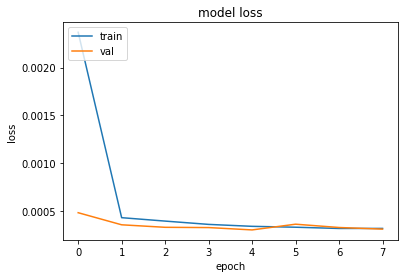

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test phase

46/46 [==============================] - 1s 7ms/step
MAE (Temp_IN):  0.8284
RMSE (Temp_IN):  1.0685


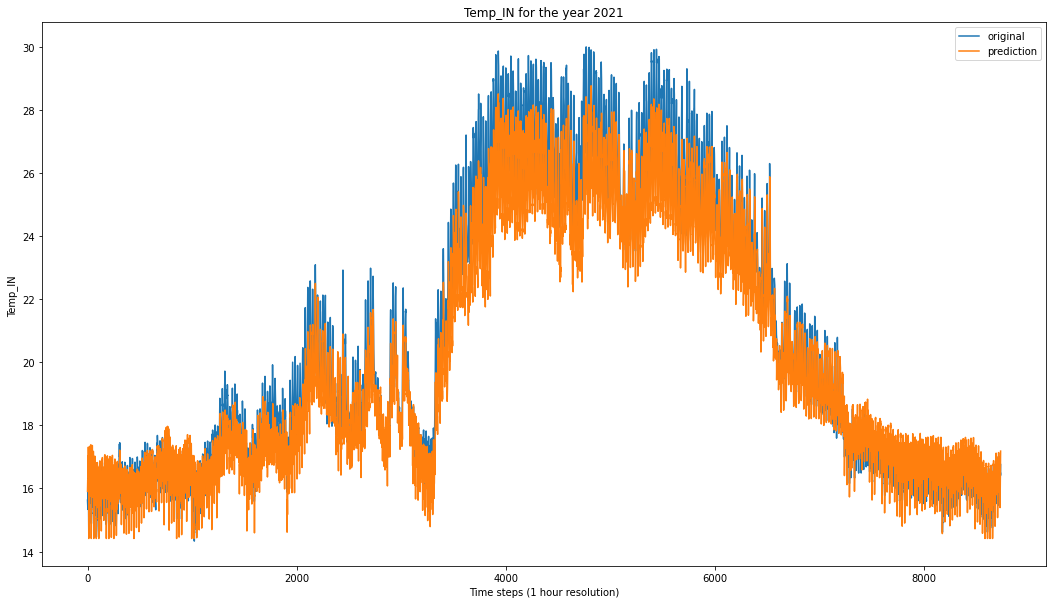

In [31]:
model.load_weights(f'Temp_IN/cnn_lstm.h5')
final_pred = {}

out = model.predict(testX)

for i, reg in enumerate(regressands):
    temp = out[:, :, i] * (y_train_max[i] - y_train_min[i]) + y_train_min[i]
    # temp = out[:, :, i] * y_train_std[i]
    final_pred[reg] = temp.reshape((testX.shape[0]*next_hours))
    err = (abs(X_test.values[past_hours
                             :past_hours
                              +len(final_pred[reg]), -len(regressands)+i]-final_pred[reg])).mean()
    rmse = math.sqrt(((X_test.values[past_hours
                                     :past_hours
                                      +len(final_pred[reg]), -len(regressands)+i]-final_pred[reg])**2).mean())
    print(f'MAE ({regressands[0].split(":")[0]}): ', round(err, 4))
    print(f'RMSE ({regressands[0].split(":")[0]}): ', round(rmse, 4))

    fig = plt.figure(figsize=(18,10))
    plt.title(reg)
    plt.plot(X_test.values[past_hours
                           :past_hours
                            +len(final_pred[reg]), 4+len(features)+i], label='original')
    plt.plot(final_pred[reg], label=f'prediction')
    plt.ylabel(f'Temp_IN ')
    plt.xlabel('Time steps (1 hour resolution)')
    plt.title(f'Temp_IN for the year 2021')
    plt.legend()
    plt.show()

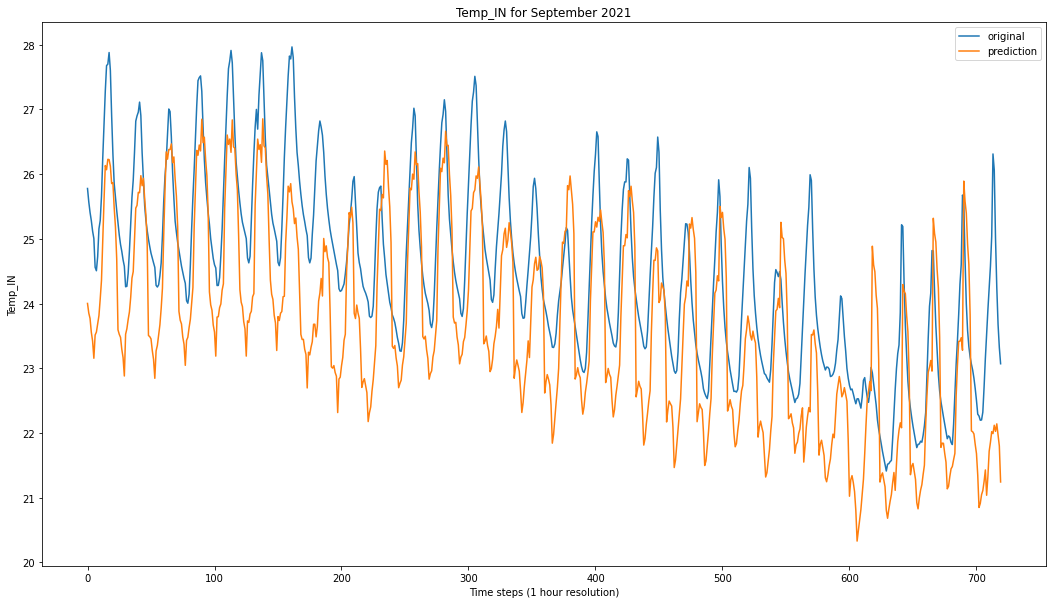

In [32]:
for i, reg in enumerate(regressands):
    fig = plt.figure(figsize=(18,10))
    plt.title(reg)
    plt.plot(X_test.values[24*243:24*273, 4+len(features)+i], label='original')
    plt.plot(final_pred[reg][24*243:24*273], label=f'prediction')
    plt.ylabel(f'Temp_IN')
    plt.xlabel('Time steps (1 hour resolution)')
    plt.title(f'Temp_IN for September 2021')
    plt.legend()
    plt.show()

In [54]:
# Loading the dataset and splitting it into train and test subsets
days = []
months = []
hours = []
years = []
minutes = []
for timestamp in df_train['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    hours.append(timestamp.hour)
    years.append(timestamp.year)
    minutes.append(timestamp.minute)

X_train = pd.DataFrame()
X_train['day'] = days
X_train['month'] = months
X_train['year'] = years
X_train['hour'] = hours
X_train['minute'] = minutes

X_train.index = df_train.index
X_train = X_train.join(df_train[regressands])

X_train = X_train.astype('float32')
normalized_X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
normalized_X_train.dropna(axis=1, inplace=True)
y_train_min, y_train_max = X_train[regressands].min(), X_train[regressands].max()
y_train_mean, y_train_std = X_train[regressands].mean(), X_train[regressands].std()

# Loading the test dataset
days = []
months = []
years = []
hours = []
minutes = []
for timestamp in df_test['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    years.append(timestamp.year)
    hours.append(timestamp.hour)
    minutes.append(timestamp.minute)

X_test = pd.DataFrame()
X_test['day'] = days
X_test['month'] = months
X_test['year'] = years
X_test['hour'] = hours
X_test['minute'] = minutes
X_test.index = df_test.index
X_test = X_test.join(df_test[regressands])

X_test = X_test.astype('float32')
normalized_X_test=(X_test-X_train.min())/(X_train.max()-X_train.min())
normalized_X_test.dropna(axis=1, inplace=True)
#normalized_X_test=(X_test-X_test.min())/(X_test.max()-X_test.min())
y_test_min, y_test_max = X_test[regressands].min(), X_test[regressands].max()

In [56]:
sizes = np.array([6, 12, 24, 48, 72, 96, 120, 144, 168])
mae_values = {}
rmse_values = {}
for i in sizes:
    past_hours= i
    next_hours = 1
    print(f'past_hours'
          f': {past_hours}')
    print(f'next_hours: {next_hours}')
    trainX, trainY = [], []
    for j in range(past_hours
            , len(normalized_X_train.index)-next_hours, 1):
        input, val = normalized_X_train.values[j-past_hours
                                               :j, :], normalized_X_train.values[j:j+next_hours,-len(regressands):]  # I know that regressands are the last columns
        trainX.append(input)
        trainY.append(val)

    val_size = 24*60  # 2 months
    valX = []
    valY = []
    for v in range(val_size):
        rand_i = random.choice(range(len(trainX)))
        valX.append(trainX.pop(rand_i))
        valY.append(trainY.pop(rand_i))

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    valX = np.array(valX)
    valY = np.array(valY)
    print(f'trainX shape: {trainX.shape}')
    print(f'trainY shape: {trainY.shape}')
    print(f'valX shape: {valX.shape}')
    print(f'valY shape: {valY.shape}')

    testX = []
    for t in range(past_hours
            , len(normalized_X_test.index)-next_hours, next_hours):
        testX.append(normalized_X_test.values[t-past_hours
                                              :t, :])
    testX = np.array(testX)
    print(f'testX shape: {testX.shape}')
    print("")
    # Model
    model = Sequential()
    model.add(Reshape((past_hours
                       , normalized_X_train.shape[1], 1), input_shape=(past_hours
                                                                       , normalized_X_train.shape[1])))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(32))
    model.add(Dense(next_hours*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((next_hours, len(regressands))))
    #
    model.compile(loss='mse', optimizer='adam', metrics='mean_absolute_error')
    # print(model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
    mc = ModelCheckpoint(f'Temp_IN/{i}H_forecast.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

    print(f'Forecasting {i}H ahead...')
    try:
        model.load_weights(f'Temp_IN/{i}H_forecast.h5')
        print('Already trained model found!')
    except:
        history = model.fit(x=trainX, y=trainY, batch_size=10, epochs=30, shuffle=True, validation_data=(valX, valY), callbacks=[es, mc])
    print('\n-------------------------- ----\n')

    model.load_weights(f'Temp_IN/{i}H_forecast.h5')

    final_pred = model.predict(testX)[:,:,0]*(y_train_max.iloc[0]-y_train_min.iloc[0])+y_train_min.iloc[0]

    final_pred = final_pred.reshape((testX.shape[0]*next_hours))

    mae = (abs(X_test.values[past_hours
                             :past_hours
                              +len(final_pred), -1]-final_pred)).mean()
    rmse = math.sqrt(((X_test.values[past_hours
                                     :past_hours
                                      +len(final_pred), -1]-final_pred)**2).mean())

    mae_values[f'{i}H'] = [mae]
    rmse_values[f'{i}H'] = [rmse]

past_hours: 6
next_hours: 1
trainX shape: (24833, 6, 5)
trainY shape: (24833, 1, 1)
valX shape: (1440, 6, 5)
valY shape: (1440, 1, 1)
testX shape: (8753, 6, 5)

Forecasting 6H ahead...
Already trained model found!

-------------------------- ----

274/274 [==============================] - 1s 3ms/step
past_hours: 12
next_hours: 1
trainX shape: (24827, 12, 5)
trainY shape: (24827, 1, 1)
valX shape: (1440, 12, 5)
valY shape: (1440, 1, 1)
testX shape: (8747, 12, 5)

Forecasting 12H ahead...
Already trained model found!

-------------------------- ----

274/274 [==============================] - 1s 4ms/step
past_hours: 24
next_hours: 1
trainX shape: (24815, 24, 5)
trainY shape: (24815, 1, 1)
valX shape: (1440, 24, 5)
valY shape: (1440, 1, 1)
testX shape: (8735, 24, 5)

Forecasting 24H ahead...
Already trained model found!

-------------------------- ----

273/273 [==============================] - 1s 4ms/step
past_hours: 48
next_hours: 1
trainX shape: (24791, 48, 5)
trainY shape: (24791, 1

In [57]:
pred_x = [x for x in sizes]
pred_y_rmse = []
pred_y_mae = []
print( mae_values.keys())
for k in mae_values.keys():
    print(f'k {k} mae_values.keys {mae_values.keys}')
    pred_y_rmse.append(rmse_values[k][0])
    pred_y_mae.append(mae_values[k][0])

errors_df = pd.DataFrame({'past_hours'
                          ' [hours]': pred_x, 'MAE': pred_y_mae, 'RMSE': pred_y_rmse})
errors_df.to_csv(f'Temp_IN/errors.csv', index=False)

dict_keys(['6H', '12H', '24H', '48H', '72H', '96H', '120H', '144H', '168H'])
k 6H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 12H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 24H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 48H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 72H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 96H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 120H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 144H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>
k 168H mae_values.keys <built-in method keys of dict object at 0x0000015A1B6E9780>


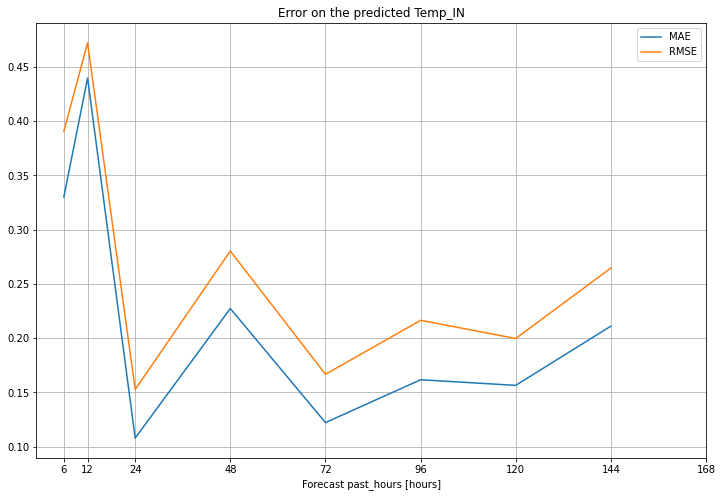

In [59]:
plt.figure(figsize=(12,8))
plt.plot(pred_x[0:-1], pred_y_mae[0:-1], label='MAE')
plt.plot(pred_x[0:-1], pred_y_rmse[0:-1], label='RMSE')
plt.xlabel('Forecast past_hours'
           ' [hours]')
plt.title(f'Error on the predicted Temp_IN')
plt.xticks(pred_x)
plt.grid()
plt.savefig(f'Temp_IN/errors_plot')
plt.legend()